Prodigy InfoTech ML Internship - Task 3

The Dataset contains 25,000 images of dogs and cats. We need to create a Support Vector Machine (SVM) Algorithm to classify each image.

Objective : Train your algorithm on the files to distinguish dogs from cats and predict the labels (1 = dog, 0 = cat).

Dataset : https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip

# Importing Necessary Libraries

In [30]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
import cv2
import joblib 
from tqdm import tqdm

In [2]:
from zipfile import ZipFile

train = "train.zip"

with ZipFile(train, 'r') as zip:
    zip.extractall()

# Some file and directory management
Here we set up the directory structure for the dataset and the paths for saving the confusion matrix image, classification report, and trained model.

In [3]:
folder_path = f"Dataset/"
os.makedirs(folder_path, exist_ok=True)

confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

dataset_dir = "Dataset/"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test1")

# Loading, Preprocessing, and assigning labels to the data
Here we assign label to each image then we preprocess it and flattening it to array, and finally store images and labels into variables.

In [6]:
images_for_train = os.listdir(train_dir)
features = []
labels = []
images_size = (50,50)

for image in tqdm(images_for_train, desc="Processing in Progress"):
    if image[0:3] == 'cat':
        label = 0
    else:
        label = 1
    
    read_image = cv2.imread(train_dir+"/"+image)
    resized_image = cv2.resize(read_image, images_size)
    normalized_image = resized_image / 255.0
    flatten_image = normalized_image.flatten()
    features.append(flatten_image)
    labels.append(label)

Processing in Progress: 100%|██████████| 25000/25000 [02:16<00:00, 183.11it/s]


In [7]:
#As it's not required anymore
del images_for_train

# Split Train and Test Data

In [8]:
features = np.asarray(features)
labels = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [9]:
#As it's not required anymore
del features
del labels

# Setting up a ML Pipeline 
Principal Component Analysis (PCA) is a technique used to reduce the dimensionality of data while preserving as much variability as possible, and SVM is a reliable algorithm here as it is a supervised machine learning algorithm used for classification.

We created here a Pipeline to chain together the two steps

In [17]:
# This is initial value Specifies that PCA should retain 80% of the variance
components_num = 0.8 

pca = PCA(n_components=components_num, random_state=42)
svm = SVC()

pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

# Cross-Valiadtion
During grid search, different combinations of these parameters will be tried, and the best combination will be selected based on cross-validation performance.

In [18]:
parameter_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8], # Different number of PCA components to try
    'svm__kernel' : ['linear', 'rbf', 'poly', 'sigmoid'], # Different SVM kernels to try
}

# Training the model 

In [22]:
#record the starting time (before training)
start_time = time.time()

grid_search = GridSearchCV(pipeline, parameter_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)

#record the ending time (after training)
end_time = time.time()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END pca__n_components=2, svm__kernel=linear;, score=0.528 total time=  12.1s
[CV 2/3] END pca__n_components=2, svm__kernel=linear;, score=0.525 total time=  11.9s
[CV 3/3] END pca__n_components=2, svm__kernel=linear;, score=0.537 total time=  11.6s
[CV 1/3] END pca__n_components=2, svm__kernel=rbf;, score=0.570 total time=   9.5s
[CV 2/3] END pca__n_components=2, svm__kernel=rbf;, score=0.560 total time=   9.4s
[CV 3/3] END pca__n_components=2, svm__kernel=rbf;, score=0.564 total time=   9.4s
[CV 1/3] END pca__n_components=2, svm__kernel=poly;, score=0.504 total time=   6.8s
[CV 2/3] END pca__n_components=2, svm__kernel=poly;, score=0.486 total time=   6.7s
[CV 3/3] END pca__n_components=2, svm__kernel=poly;, score=0.492 total time=   6.7s
[CV 1/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.507 total time=   6.3s
[CV 2/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.495 total time=   6.2s
[CV 3/

In [23]:
#As it's not required anymore
del X_train
del y_train

# Determining the best parameters & score
The grid searching technique found that using the Radial Basis Function (RBF) kernel & retaining 90% of the variance would give us the highest accuracy of 67.38%.

In [24]:
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'pca__n_components': 0.9, 'svm__kernel': 'rbf'}
Best Score:  0.6738502183801701


In [26]:
accuracy = best_pipeline.score(X_test, y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.6846


# Testing the best model 
Here we evaluate the model performance on a test dataset, then we print a Classification Report and save it.

In [31]:
y_pred = best_pipeline.predict(X_test)

target_names = ['Cat', 'Dog']
classification_rep = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", classification_rep)

with open(classification_file_path, 'w') as file:
    file.write(classification_rep)

Classification Report:
               precision    recall  f1-score   support

         Cat       0.69      0.69      0.69      2515
         Dog       0.68      0.68      0.68      2485

    accuracy                           0.68      5000
   macro avg       0.68      0.68      0.68      5000
weighted avg       0.68      0.68      0.68      5000



# Creating a Confusion Matrix
Visualizing the model performance

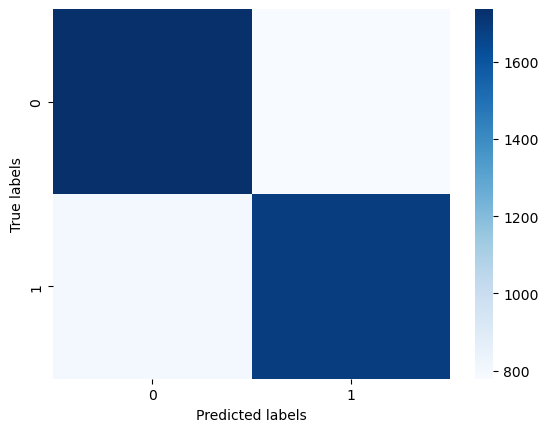

In [40]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(confusion_image_path)
plt.show()